In [1]:
import wave_networks.test as test

test.hello_world()

Hello World


In [2]:
# https://soundata.readthedocs.io/en/latest/source/tutorial.html
import soundata
urbansound8k = soundata.initialize('urbansound8k', data_home='/homes/55/bwilop/gdl/ablation_study_wavelet_networks/data')
# urbansound8k.download()  
# urbansound8k.validate() 
clip = urbansound8k.choice_clip()  
# print(clip)  
# print(len(urbansound8k.clip_ids))

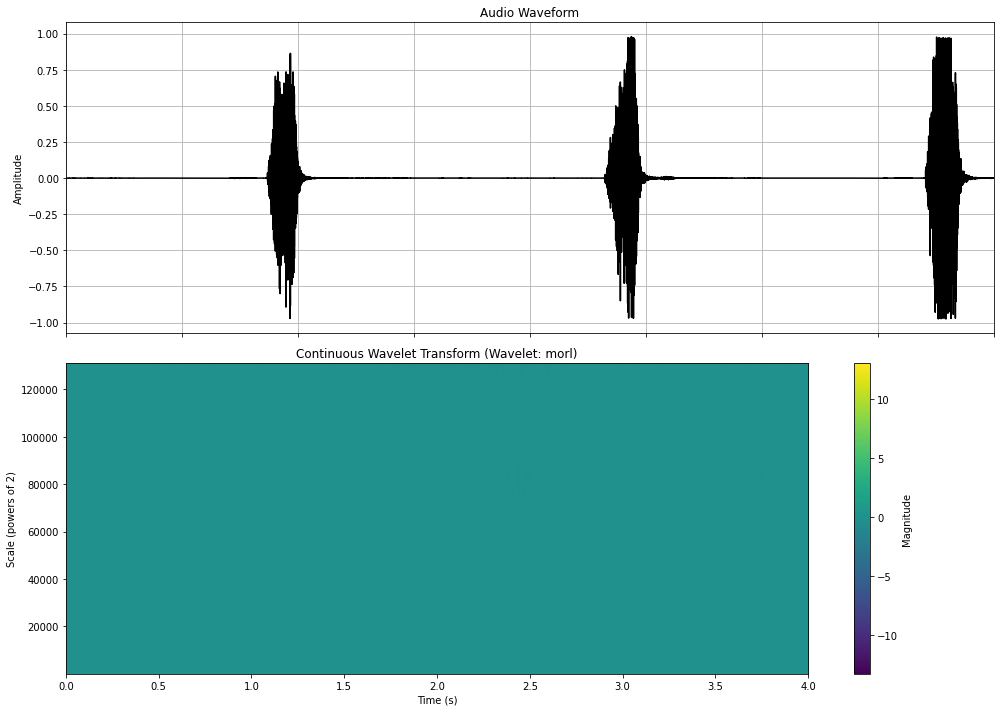

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pywt

def plot_waveform_and_wavelet(clip, wavelet='morl'):
    """
    Plots the waveform and the continuous wavelet transform (CWT) of an audio clip.
    
    The wavelet transform is computed using scales that are powers of 2 (i.e. 1, 2, 4, 8, ...)
    up to the maximal power of 2 that is still smaller than the length of the audio signal.
    
    Parameters
    ----------
    clip : soundata clip object
        A clip object returned by soundata.initialize(...).choice_clip() or similar.
        It must provide clip.audio which returns a tuple (signal, sample_rate).
    wavelet : str, optional
        The type of wavelet to use for the CWT (default is 'morl').
    """
    # Extract audio samples and sampling rate
    signal, sr = clip.audio
    time_axis = np.linspace(0, len(signal) / sr, num=len(signal))
    
    # Determine the maximum power of 2 that is smaller than the length of the signal.
    max_power = int(math.floor(math.log2(len(signal))))
    # Ensure that 2**max_power is strictly less than len(signal)
    if 2**max_power >= len(signal):
        max_power -= 1
    # Define scales: powers of 2 from 2**0 up to 2**max_power
    max_power = min(20, max_power)
    scales = [2**i for i in range(max_power + 1)]
    
    # Compute the CWT using the specified wavelet and the defined scales
    coeffs, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=1/sr)
    log_coeffs = coeffs# np.log10(np.abs(coeffs) + 0.1)
    
    # Create a figure with two subplots: one for the waveform and one for the wavelet transform
    fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Plot the waveform on the top subplot
    axs[0].plot(time_axis, signal, color='black')
    axs[0].set_title("Audio Waveform")
    axs[0].set_ylabel("Amplitude")
    axs[0].grid(True)
    
    # Plot the wavelet transform on the bottom subplot
    im = axs[1].imshow(
        log_coeffs,
        extent=[time_axis[0], time_axis[-1], scales[-1], scales[0]],
        cmap='viridis',
        aspect='auto'
    )
    axs[1].invert_yaxis()  # so that lower scales (higher frequencies) are on top
    axs[1].set_title(f"Continuous Wavelet Transform (Wavelet: {wavelet})")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Scale (powers of 2)")
    fig.colorbar(im, ax=axs[1], label='Magnitude')
    
    plt.tight_layout()
    plt.show()


# plot_waveform_and_wavelet(clip, wavelet='morl')

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import soundata

# Initialize the UrbanSound8K dataset from Soundata.

# Test code: choose a random clip and print info.
clip = urbansound8k.choice_clip()
print(clip)
print("Total number of clips:", len(urbansound8k.clip_ids))


# Name of the pickle file where statistics are saved.
STATS_PKL = "/homes/55/bwilop/gdl/ablation_study_wavelet_networks/calculated_data/urbansound_stats.pkl"

def compute_and_save_stats(pkl_filename=STATS_PKL):
    """
    Iterates over all clips in UrbanSound8K and computes:
      - fold_label_counts: a dictionary of {fold: {label: count, ...}, ...}
      - sample_rates: list of sample rates
      - durations: list of durations (in seconds)
      - max_amplitudes: list of maximum absolute amplitude values
      - foreground_count and background_count: counts of clips based on salience

    The resulting dictionary is saved as a pickle file and also returned.
    """
    stats = {
        "fold_label_counts": {},   # e.g. {fold: {label: count, ...}, ...}
        "sample_rates": [],
        "durations": [],
        "max_amplitudes": [],
        "foreground_count": 0,
        "background_count": 0,
    }

    clip_ids = urbansound8k.clip_ids
    total = len(clip_ids)
    print(f"Processing {total} clips...")

    for i, clip_id in enumerate(clip_ids):
        if i % 50 == 0:
            print(i)
        clip = urbansound8k.clip(clip_id)
        
        # --- Fold and Label ---
        # UrbanSound8K clips have a 'fold' and a 'class_label' attribute.
        fold = getattr(clip, "fold", None)
        label = getattr(clip, "class_label", None)
        if fold is None or label is None:
            continue
        if fold not in stats["fold_label_counts"]:
            stats["fold_label_counts"][fold] = {}
        stats["fold_label_counts"][fold][label] = stats["fold_label_counts"][fold].get(label, 0) + 1

        # --- Audio metadata: sample rate and duration ---
        # According to the Soundata tutorial, clip.audio is an AudioData object
        # with properties: data (audio signal), sample_rate, and duration.
        sr = clip.audio[1]
        dur = len(clip.audio[0]) / sr
        stats["sample_rates"].append(sr)
        stats["durations"].append(dur)

        # --- Maximum amplitude ---
        # Assume clip.audio.data is a NumPy array. If not, convert it.
        audio = clip.audio[0]
        if not isinstance(audio, np.ndarray):
            audio = np.array(audio)
        max_amp = np.max(np.abs(audio))
        stats["max_amplitudes"].append(max_amp)

        # --- Foreground vs. Background ---
        # UrbanSound8K annotations typically have a 'salience' attribute.
        # In many cases salience is defined as 1 for foreground and 2 for background.
        # (Some versions may store it as a string, e.g., 'foreground'.)
        salience = None
        if hasattr(clip, "annotations") and hasattr(clip.annotations, "salience"):
            salience = clip.annotations.salience
        elif hasattr(clip, "salience"):
            salience = clip.salience

        if salience is not None:
            try:
                # Try to convert salience to integer (if it is given as 1 or 2).
                if int(salience) == 1:
                    stats["foreground_count"] += 1
                else:
                    stats["background_count"] += 1
            except Exception:
                # Otherwise, compare strings.
                if str(salience).lower() == "foreground":
                    stats["foreground_count"] += 1
                else:
                    stats["background_count"] += 1

        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{total} clips...")

    # Save the computed stats to a pickle file.
    os.makedirs(os.path.dirname(pkl_filename), exist_ok=True)
    with open(pkl_filename, "wb") as f:
        pickle.dump(stats, f)
    print(f"Statistics saved to {pkl_filename}.")
    return stats

def load_stats(pkl_filename=STATS_PKL):
    """
    Loads statistics from the pickle file if it exists.
    """
    if os.path.exists(pkl_filename):
        with open(pkl_filename, "rb") as f:
            stats = pickle.load(f)
        print(f"Loaded statistics from {pkl_filename}.")
        return stats
    else:
        print(f"No stats file found at {pkl_filename}.")
        return None

def get_stats(pkl_filename=STATS_PKL):
    """
    Returns the statistics dictionary, computing and saving if necessary.
    """
    stats = load_stats(pkl_filename)
    if stats is None:
        stats = compute_and_save_stats(pkl_filename)
    return stats


# ---------------------------
# Plotting methods
# ---------------------------
def plot_fold_label_bar(stats):
    """
    Plots a stacked bar chart with one bar per fold.
    Each bar is segmented according to the counts of each label.
    """
    fold_counts = stats["fold_label_counts"]
    folds = sorted(fold_counts.keys())
    
    # Gather all unique labels across folds.
    all_labels = sorted({label for fold in fold_counts.values() for label in fold.keys()})
    
    # Prepare the count data.
    data = {label: [] for label in all_labels}
    for fold in folds:
        for label in all_labels:
            data[label].append(fold_counts[fold].get(label, 0))
    
    ind = np.arange(len(folds))
    bottom = np.zeros(len(folds))
    plt.figure(figsize=(10, 6))
    for label in all_labels:
        plt.bar(ind, data[label], bottom=bottom, label=label)
        bottom += np.array(data[label])
    plt.xlabel("Fold")
    plt.ylabel("Count")
    plt.title("Label Distribution per Fold")
    plt.xticks(ind, folds)
    plt.legend(title="Label")
    plt.show()

def plot_sample_rate_histogram(stats):
    """
    Plots a histogram of the sample rates.
    """
    sample_rates = stats["sample_rates"]
    plt.figure(figsize=(8, 5))
    plt.hist(sample_rates, bins=20, edgecolor="k")
    plt.xlabel("Sample Rate")
    plt.ylabel("Frequency")
    plt.title("Histogram of Sample Rates")
    plt.show()

def plot_duration_histogram(stats):
    """
    Plots a histogram of the clip durations.
    """
    durations = stats["durations"]
    plt.figure(figsize=(8, 5))
    plt.hist(durations, bins=20, edgecolor="k")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Durations")
    plt.show()

def plot_max_amplitude_histogram(stats):
    """
    Plots a histogram of the maximum amplitude values.
    """
    max_amplitudes = stats["max_amplitudes"]
    plt.figure(figsize=(8, 5))
    plt.hist(max_amplitudes, bins=20, edgecolor="k")
    plt.xlabel("Max Amplitude")
    plt.ylabel("Frequency")
    plt.title("Histogram of Maximum Amplitudes")
    plt.show()

def print_foreground_background(stats):
    """
    Prints the number of foreground versus background clips.
    """
    fg = stats.get("foreground_count", 0)
    bg = stats.get("background_count", 0)
    print(f"Foreground clips: {fg}")
    print(f"Background clips: {bg}")


# stats = get_stats(STATS_PKL)
# # Plot stacked bar chart for fold/label distribution.
# plot_fold_label_bar(stats)
# # Plot histograms.
# plot_sample_rate_histogram(stats)
# plot_duration_histogram(stats)
# plot_max_amplitude_histogram(stats)
# # Print foreground/background counts.
# print_foreground_background(stats)


NameError: name 'urbansound8k' is not defined

: 

: 

: 

: 

In [ ]:
(np.array(stats['sample_rates'])==44100).all()

True

: 

: 

: 

: 

: 

: 

In [ ]:
(np.array(stats['durations'])==4.0).mean()

0.0009161704076958314

: 

: 

: 

: 

: 

: 

In [ ]:
max(stats['durations'])

4.036666666666667

: 

: 

: 

: 

: 

: 

In [ ]:
clip.audio[0].shape

(176400,)

: 

: 

: 

: 

: 

: 

/homes/55/bwilop/gdl/wavelet_networks/wavelet_networks/wavelet_networks_venv/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'urbansound8k' is not defined

: 

: 

: 

: 